In [47]:
import calendar
import os
import random
import re
from datetime import date

import dateutil
import graphistry
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import requests
import seaborn as sns

# Part 2: Quantitative Networks: Social Network Analysis and Network Science

Having reviewed the theory of network science and graph machine learning in Part 1, it is time to start coding! In this part of the course we will survey network science. Please keep in mind that as a multidisciplinary field, network science is impossible to cover completely.

Albert-László Barabási has written a [comprehensive book on network science](http://networksciencebook.com/chapter/2) that provides more in depth treatment of topics like [graph theory](http://networksciencebook.com/chapter/2), [random networks](http://networksciencebook.com/chapter/3) and [communities](http://networksciencebook.com/chapter/9).

## High-energy Physics Theory Citation Network

We are going to be using the [High-energy physics theory citation network](https://snap.stanford.edu/data/cit-HepTh.html) from [Stanford SNAP](https://snap.stanford.edu/index.html) which has many large network datasets available in the [Stanford Large Network Dataset Collection](https://snap.stanford.edu/data/).

The dataset includes:

* [Citation graph edge list](https://snap.stanford.edu/data/cit-HepTh.txt.gz) contains node ID pairs. Node IDs are standard paper identifiers. This will build the core structure of our network.
* [Paper metadata](cit-HepTh-abstracts.tar.gz) including abstracts. This will add propertis to our network.
* [Publishing dates on arXiv](https://snap.stanford.edu/data/cit-HepTh-dates.txt.gz) will make our citation network a temporal [Directed-Acyclic-Graph (DAG)](https://en.wikipedia.org/wiki/Directed_acyclic_graph) since one paper can't cite another before it is written and there are no reciprocal edges. While we don't focus on this, it does affect our analysis.

## Setting up Graphistry

Throughout this part of the course we will be using `pygraphistry` and [Graphistry Hub](https://hub.graphistry.com/) [https://hub.graphistry.com/](https://hub.graphistry.com/) to visualize networks. Both are free for personal use and are powerful for visualizing networks large and small.

You can [signup](https://hub.graphistry.com/accounts/signup/) for a Graphistry account at [https://hub.graphistry.com/accounts/signup/](https://hub.graphistry.com/accounts/signup/). <b>You should use a username/password/email to get the required credentials</b>, although after that you can login with your Github or Google account.

<center><img src="images/graphistry_hub_registration.png" /></center>

Retain and use your credentials in the login form and in the environment variables in the next cell below. You should set the `GRAPHISTRY_USERNAME` and `GRAPHISTRY_PASSWORD` variables in the `env/graphistry.env` file, and then restart this docker container to pickup the new values.

<center><img src="images/graphistry_hub_homepage.png" /></center>

In [48]:
# Environment variable setup
GRAPHISTRY_USERNAME = os.getenv("GRAPHISTRY_USERNAME")
GRAPHISTRY_PASSWORD = os.getenv("GRAPHISTRY_PASSWORD")

In [49]:
graphistry.register(
    api=3,
    username=GRAPHISTRY_USERNAME,
    password=GRAPHISTRY_PASSWORD,
)

# Network Science on Citation Networks

We start with an example of a citation network: [High-energy physics theory citation network](https://snap.stanford.edu/data/cit-HepTh.html) from [Stanford SNAP](http://snap.stanford.edu/). A citation network describes how one academic paper cites another one.

> Arxiv HEP-TH (high energy physics theory) citation graph is from the e-print arXiv and covers all the citations within a dataset of 27,770 papers with 352,807 edges. If a paper i cites paper j, the graph contains a directed edge from i to j. If a paper cites, or is cited by, a paper outside the dataset, the graph does not contain any information about this.
>
> The data covers papers in the period from January 1993 to April 2003 (124 months). It begins within a few months of the inception of the arXiv, and thus represents essentially the complete history of its HEP-TH section.
>
> The data was originally released as a part of [2003 KDD Cup](http://www.cs.cornell.edu/projects/kddcup/).

J. Leskovec, J. Kleinberg and C. Faloutsos. [Graphs over Time: Densification Laws, Shrinking Diameters and Possible Explanations.](http://www.cs.cmu.edu/~jure/pubs/powergrowth-kdd05.pdf) ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2005.

## NetworkX

The [networkx Algorithms documentation](https://networkx.org/documentation/stable/reference/algorithms/index.html) lists a fairly comprehensive set of tools available for the network scientist. We will be using networkx throughout the course.

## cuGraph

The [NVIDIA RAPIDS cuGraph](https://docs.rapids.ai/api/cugraph/stable/) ([Github](https://github.com/rapidsai/cugraph)) is a GPU accelerated graph analytics library that is roughly compatible with `networkx`. It can rapidly compute expensive metrics compare to CPU, where processing is often limited to a single core.

An NVIDIA GPU and cuGraph are optional in this course, but will be helpful as you use complex algorithms on large networks.

## Extract Edge List and Build Directional Graph (DiGraph)

First we download the edge list and build the structure of the network: `(paper)-cited->(paper)`

In [50]:
import gzip
import io
import networkx as nx
import tarfile

from typing import Dict

# Initialize a directed graph
G = nx.DiGraph()

# Download and load edges (citations) from `cit-HepTh.txt.gz`
response = requests.get("https://snap.stanford.edu/data/cit-HepTh.txt.gz")
gzip_content = io.BytesIO(response.content)

with open("data/cit-HepTh.txt.gz", "wb") as f:
    f.write(response.content)
    print("Wrote edge file to data/cit-HepTh.txt.gz")

idx_to_key: Dict[int, str] = {}
key_to_idx: Dict[str, int] = {}
current_idx = 0

# Decompress the gzip content and build the edge list for our network
with gzip.GzipFile(fileobj=gzip_content) as f:
    for line in f:
        line = line.decode('utf-8')
        # Ignore lines that start with '#'
        if not line.startswith('#'):

            # Source (citing), desstination (cited) papers
            citing_key, cited_key = line.strip().split('\t')

            # If the papers don't have an integer ID, make one
            for key in [cited_key, citing_key]:
                
                if key not in key_to_idx:

                    # Build up an index that maps back and forth
                    key_to_idx[key] = current_idx
                    idx_to_key[current_idx] = key

                    # Bump the current ID
                    current_idx += 1
            
            G.add_edge(key_to_idx[citing_key], key_to_idx[citing_key])

            # Conditionally set the keys on the nodes
            G.nodes[key_to_idx[citing_key]]["key"] = citing_key
            G.nodes[key_to_idx[citing_key]]["idx"] = key_to_idx[citing_key]
            G.nodes[key_to_idx[citing_key]]["key"] = cited_key
            G.nodes[key_to_idx[citing_key]]["idx"] = key_to_idx[cited_key]

Wrote edge file to data/cit-HepTh.txt.gz


## Summarize the Properties of our DiGraph

Let's check how many nodes and edges we have. This will help evaluate how we are doing when we parse the abstracts to add properties to our DiGraph.

In [51]:
print(f"Total nodes: {G.number_of_nodes():,}")
print(f"Total edges: {G.number_of_edges():,}")
print(f"Total components: {nx.number_connected_components(G.to_undirected()):,}")
print(f"Undirected is weakly connected: {nx.is_weakly_connected(G)}")

Total nodes: 25,059
Total edges: 25,059
Total components: 25,059
Undirected is weakly connected: False


### ChatGPT4 and Russell Jurney say...

In [44]:
def describe_graph(G):
    """Given a networkx Graph, describe its key properties."""

    print(f"Number of nodes: {G.number_of_nodes():,}")
    print(f"Number of edges: {G.number_of_edges():,}")

    # Compute various network properties
    degrees = [deg for node, deg in nx.degree(G)]
    avg_degree = sum(degrees) / G.number_of_nodes()
    print(f"Average degree: {avg_degree:,.3f}")

    components = nx.connected_components(G.to_undirected())
    largest_component = max(components, key=len)
    print(f"Number of connected components: {nx.number_connected_components(G.to_undirected()):,}")
    print(f"Size of the largest component: {len(largest_component):,}")

    # If the network is directed, you can also print the following
    if G.is_directed():
        print(f"Number of strongly connected components: {nx.number_strongly_connected_components(G):,}")
        print(f"Number of weakly connected components: {nx.number_weakly_connected_components(G):,}")

    avg_clustering = nx.average_clustering(G)
    print(f"Average clustering coefficient: {avg_clustering:.6f}")

    try:
        avg_shortest_path_length = nx.average_shortest_path_length(G)
        print(f"Average shortest path length: {avg_shortest_path_length}")
    except nx.NetworkXError:
        print("Graph is not connected, average shortest path length is not defined.")

describe_graph(G)

Number of nodes: 25,059
Number of edges: 25,059
Average degree: 2.000
Number of connected components: 25,059
Size of the largest component: 1
Number of strongly connected components: 25,059
Number of weakly connected components: 25,059
Average clustering coefficient: 0.000000
Graph is not connected, average shortest path length is not defined.


### Histogram of Connected Component Sizes

134 components - our graph is not one large hairball! Let's see what sizes our connected components are. Usually these are a power law distribution, with one large component taking up 30 or more percent of nodes and edges.

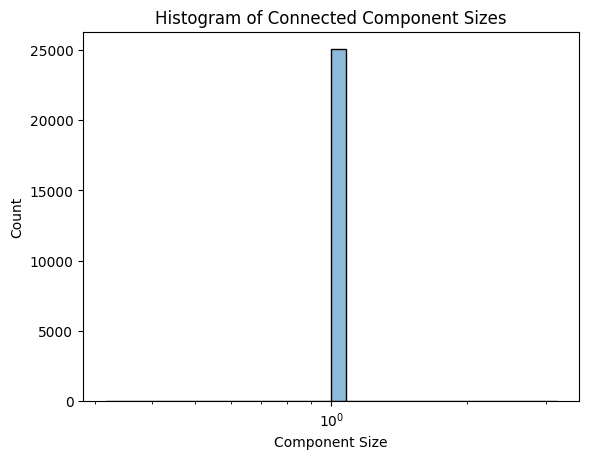

In [37]:
# Get connected components and their sizes
components = nx.connected_components(G.to_undirected())
component_sizes = [len(c) for c in components]

# Use seaborn to create the histogram
sns.histplot(component_sizes, kde=True, bins=30, log_scale=True)
plt.title('Histogram of Connected Component Sizes')
plt.xlabel('Component Size')
plt.ylabel('Count')
plt.show()

## Average Clustering Coefficient

>The clustering coefficient is an indicator of the interconnectedness or cohesion among nodes in a graph. It's a measure of the extent to which the immediate neighbors of a particular node link to each other.
>
>The range of a clustering coefficient is between 0 and 1:
>
>When the clustering coefficient is 0, it signifies a scenario where none of the nodes have direct connections with each other. This can be seen in graphs such as a tree or a radial network where nodes are only connected to a central hub, but not with each other.
>
>In contrast, a clustering coefficient of 1 indicates a fully connected graph. Here, each node in the graph is directly linked with all other nodes.

--ChatGPT4 and Russell Jurney

In [38]:
# A good start...
print(f"Average degree: {G.number_of_edges()/G.number_of_nodes():.3f}")
print(f"Median degree: {np.median([deg for node, deg in G.degree()]):.3f}")

clustering_coefficient = nx.average_clustering(G)
print(f"Graph clustering coefficient: {clustering_coefficient:.3f}")
print(f"Median clustering coefficient: {np.median([coeff for node, coeff in nx.clustering(G).items()]):.3f}")

Average degree: 1.000
Median degree: 2.000
Graph clustering coefficient: 0.000
Median clustering coefficient: 0.000


>An average clustering coefficient of 0.16 in our `nx.DiGraph` implies there is a relatively low degree of clustering or tight-knit communities. It suggests a network structure that is more spread out, with fewer connections among immediate neighbors of each node. Networks such as web pages or citation networks often present lower clustering coefficients, as these networks are characterized by a wide range of diverse connections that do not necessarily link back to each other. Citation networks are actually temporal networks and are constrained by the fact that papers can't cite future papers, but only past ones. They are therefore DAGs - directed, acyclic graphs.

--ChatGPT4 and Russell Jurney

### Node Clustering Coefficients

>The clustering coefficient of a node is a measure of the degree to which nodes in a graph tend to cluster together. It provides an indication of how the neighbors of a _particular node_ are interconnected. It measures how close a node's neighbors are to being a complete graph or a clique. It is defined as the fraction of possible triangles that exist through the node, or equivalently, as the fraction of the node's neighbors that are also neighbors of each other.

--ChatGPT4 and Russell Jurney

We're going to add a property to each node in the network for each node's clustering coefficient. You can find more on clustering coefficients in citation networks in [Modeling the clustering in citation networks](https://arxiv.org/abs/1104.4209).

In [10]:
clustering_coeffs = nx.clustering(G)

for node, clustering_coeff in clustering_coeffs.items():
    G.nodes[node]['clustering_coefficient'] = clustering_coeff

Let's look at how the clustering coefficient is distributed.

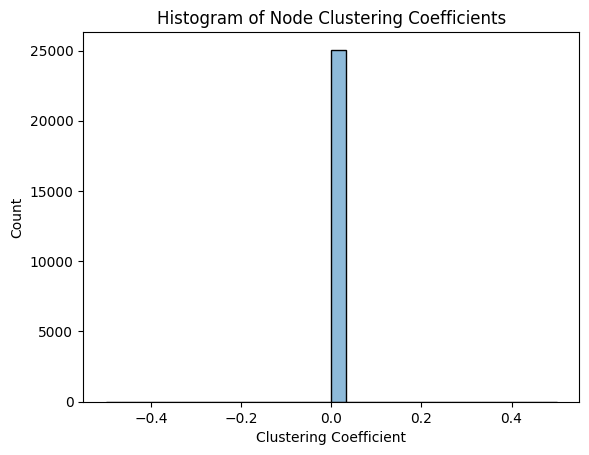

In [11]:
# Get connected components and their sizes
clustering_coeff_counts = [val for key, val in clustering_coeffs.items()]

# Use seaborn to create the histogram
sns.histplot(clustering_coeff_counts, kde=True, bins=30, log_scale=False)
plt.title('Histogram of Node Clustering Coefficients')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Count')
plt.show()

In [12]:
G.nodes[key_to_idx["9711194"]]

{'key': '9701123', 'idx': 5814, 'clustering_coefficient': 0}

A clustering coefficient of around 0.2 indicates that most nodes have relatively low (but still significant) clustering coefficients - their neighbors are sparsely connected. How does this fit with the average degree of 12 and graph clustering coefficient of 0.16? 16% of the average node's connections are connected with one another. From the histogram which has a skewed but fairly normal distribution, it looks like the _typical_ node has these properties as well. These are characteristics of a [Small World Network](https://en.wikipedia.org/wiki/Small-world_network). Most citation graphs are [small world networks](https://en.wikipedia.org/wiki/Citation_graph). 

Note: NetworkX has a set of functions [`networkx.algorithms.smallworld`](https://networkx.org/documentation/stable/reference/algorithms/smallworld.html) that can determine the "small worldiness of a network."

Why do we care what kind of theoretical graph model fits our *real world* network. Because the field of network science is multidisciplinary and papers cover topics from physics to biology to sociology to microchip design. The type of network you have - often in the same settings as yours - has been rigorously studied. Reading a paper or two describing your graph gives you the context you need to extract insights, build models and auomate tasks using machine learning and artificial intelligence.

## Add Properties to Nodes in Network

Now we will use `extract_paper_info(text)` to add structured data to the nodes in our network.

### Using ChatGPT to Write NetworkX Code

We cover Chatbots at the end of this course, I just want to point out that the following dialogue generated the basis for the code below.

```
I am going to past some text representing some semi-structured data about an academic paper below:

Paper: hep-th/0002031
From: Maulik K. Parikh 
Date: Fri, 4 Feb 2000 17:04:51 GMT   (10kb)

Title: Confinement and the AdS/CFT Correspondence
Authors: D. S. Berman and Maulik K. Parikh
Comments: 12 pages, 1 figure, RevTeX
Report-no: SPIN-1999/25, UG-1999/42
Journal-ref: Phys.Lett. B483 (2000) 271-276
\\
  We study the thermodynamics of the confined and unconfined phases of
superconformal Yang-Mills in finite volume and at large N using the AdS/CFT
correspondence. We discuss the necessary conditions for a smooth phase
crossover and obtain an N-dependent curve for the phase boundary.
\\

Now I want you to write python code to extract the fields "Paper", "From", "Date", "Title", "Authors", "Comments", "Report-no", "Journal-ref" and the last field the "Abstract" text content.
```

One cycle of correction looked like:

```
That code did not work on this record:

------------------------------------------------------------------------------
\\
Paper: hep-th/9711200
From: Juan Maldacena <malda@physics.rutgers.edu>
Date: Thu, 27 Nov 1997 23:53:13 GMT   (22kb)
Date (revised v2): Mon, 8 Dec 1997 18:59:11 GMT   (23kb)
Date (revised v3): Thu, 22 Jan 1998 15:42:41 GMT   (23kb)

Title: The Large N Limit of Superconformal Field Theories and Supergravity
Authors: Juan M. Maldacena
Comments: 20 pages, harvmac, v2: section on AdS_2 corrected, references added,
  v3: More references and a sign in eqns 2.8 and 2.9 corrected
Report-no: HUTP-98/A097
Journal-ref: Adv.Theor.Math.Phys. 2 (1998) 231-252; Int.J.Theor.Phys. 38 (1999)
  1113-1133
\\
  We show that the large $N$ limit of certain conformal field theories in
various dimensions include in their Hilbert space a sector describing
supergravity on the product of Anti-deSitter spacetimes, spheres and other
compact manifolds. This is shown by taking some branes in the full M/string
theory and then taking a low energy limit where the field theory on the brane
decouples from the bulk. We observe that, in this limit, we can still trust the
near horizon geometry for large $N$. The enhanced supersymmetries of the near
horizon geometry correspond to the extra supersymmetry generators present in
the superconformal group (as opposed to just the super-Poincare group). The 't
Hooft limit of 4-d ${\cal N} =4$ super-Yang-Mills at the conformal point is
shown to contain strings: they are IIB strings. We conjecture that
compactifications of M/string theory on various Anti-deSitter spacetimes are
dual to various conformal field theories. This leads to a new proposal for a
definition of M-theory which could be extended to include five non-compact
dimensions.
\\

It should have started the Abstract extraction with "We show that" but instead it includes the entire document. Please fix.
```

There were a few more iterations, so this is not "free." I then had to edit the code and that is what is in the cell. ChatGPT is your running mate :)

In [18]:
def extract_paper_info(record):
    """Extract structured information from the text of academic paper text records using regular expressions.
       
       Note: I was written wholly or in part by ChatGPT4 on May 23, 2023.
    """
    
    # Initialize an empty dictionary to hold the information
    info = {}
    
    # Match "Paper" field
    paper_match = re.search(r"Paper:\s*(.*)", record)
    if paper_match:
        info['Paper'] = paper_match.group(1)
        
    # # Match "From" field
    # from_match = re.search(r"From:\s*(.*)", record)
    # if from_match:
    #     info['From'] = from_match.group(1)

    # Match "From" field
    from_match = re.search(r"From:\s*([^<]*)<", record)
    if from_match:
        info['From'] = from_match.group(1).strip()
    
    # Match "Date" field
    date_match = re.search(r"Date:\s*(.*)", record)
    if date_match:
        info['Date'] = date_match.group(1)
    
    # Match "Title" field
    title_match = re.search(r"Title:\s*(.*)", record)
    if title_match:
        info['Title'] = title_match.group(1)

    # Match "Authors" field
    authors_match = re.search(r"Authors:\s*(.*)", record)
    if authors_match:
        info['Authors'] = authors_match.group(1)

    # Match "Comments" field
    comments_match = re.search(r"Comments:\s*(.*)", record)
    if comments_match:
        info['Comments'] = comments_match.group(1)

    # Match "Report-no" field
    report_no_match = re.search(r"Report-no:\s*(.*)", record)
    if report_no_match:
        info['Report-no'] = report_no_match.group(1)

    # Match "Journal-ref" field
    journal_ref_match = re.search(r"Journal-ref:\s*(.*)", record)
    if journal_ref_match:
        info['Journal-ref'] = journal_ref_match.group(1)

    # Extract "Abstract" field
    abstract_pattern = r"Journal-ref:[^\\\\]*\\\\[\n\s]*(.*?)(?=\\\\)"
    abstract_match = re.search(abstract_pattern, record, re.DOTALL)
    if abstract_match:
        abstract = abstract_match.group(1)
        abstract = abstract.replace('\n', ' ').replace('  ', ' ')
        info['Abstract'] = abstract.strip()

    return info

### Debugging Paper Metadata Parsing

The first version didn't work, so I added some documents below. I'm leaving it in the notebook can see what I did: iteratively improve document parsing (data cleaning) until the network meets the needs of our analysis, application or audience.

In [19]:
doc1 = """------------------------------------------------------------------------------
\\
Paper: hep-th/9612115
From: Asato Tsuchiya <tsuchiya@theory.kek.jp>
Date: Wed, 11 Dec 1996 17:38:56 +0900   (20kb)
Date (revised): Tue, 31 Dec 1996 01:06:34 +0900

Title: A Large-N Reduced Model as Superstring
Authors: N. Ishibashi, H. Kawai, Y. Kitazawa and A. Tsuchiya
Comments: 29 pages, Latex, a footnote and references added, eq.(3.52)
  corrected, minor corrections
Report-no: KEK-TH-503, TIT/HEP-357
Journal-ref: Nucl.Phys. B498 (1997) 467-491
\\
  A matrix model which has the manifest ten-dimensional N=2 super Poincare
invariance is proposed. Interactions between BPS-saturated states are analyzed
to show that massless spectrum is the same as that of type IIB string theory.
It is conjectured that the large-N reduced model of ten-dimensional super
Yang-Mills theory can be regarded as a constructive definition of this model
and therefore is equivalent to superstring theory.
\\
"""

doc2 = """------------------------------------------------------------------------------
\\
Paper: hep-th/9711029
From: John Schwarz <jhs@theory.caltech.edu>
Date: Wed, 5 Nov 1997 17:30:55 GMT   (20kb)
Date (revised v2): Thu, 6 Nov 1997 23:52:45 GMT   (21kb)

Title: The Status of String Theory
Author: John H. Schwarz
Comments: 16 pages, latex, two figures; minor corrections, references added
Report-no: CALT-68-2140
\\
  There have been many remarkable developments in our understanding of
superstring theory in the past few years, a period that has been described as
``the second superstring revolution.'' Several of them are discussed here. The
presentation is intended primarily for the benefit of nonexperts.
\\
"""

paper_info = extract_paper_info(doc1)
paper_id = paper_info.get("Paper", "").split("/")[-1]  # Get the paper ID part of the "Paper" field
print(paper_id, paper_info)

paper_info = extract_paper_info(doc2)
paper_id = paper_info.get("Paper", "").split("/")[-1]  # Get the paper ID part of the "Paper" field
print(paper_id, paper_info)

9612115 {'Paper': 'hep-th/9612115', 'From': 'Asato Tsuchiya', 'Date': 'Wed, 11 Dec 1996 17:38:56 +0900   (20kb)', 'Title': 'A Large-N Reduced Model as Superstring', 'Authors': 'N. Ishibashi, H. Kawai, Y. Kitazawa and A. Tsuchiya', 'Comments': '29 pages, Latex, a footnote and references added, eq.(3.52)', 'Report-no': 'KEK-TH-503, TIT/HEP-357', 'Journal-ref': 'Nucl.Phys. B498 (1997) 467-491'}
9711029 {'Paper': 'hep-th/9711029', 'From': 'John Schwarz', 'Date': 'Wed, 5 Nov 1997 17:30:55 GMT   (20kb)', 'Title': 'The Status of String Theory', 'Comments': '16 pages, latex, two figures; minor corrections, references added', 'Report-no': 'CALT-68-2140'}


In [20]:
# Download the abstracts from `cit-HepTh-abstracts.tar.gz`
abstract_response = requests.get("https://snap.stanford.edu/data/cit-HepTh-abstracts.tar.gz")

# Convert the response content to an in-memory binary stream
abstract_gzip_content = io.BytesIO(abstract_response.content)

# Decompress the gzip content
with gzip.GzipFile(fileobj=abstract_gzip_content) as f:
    with tarfile.open(fileobj=f, mode='r|') as tar:
        for member in tar:
            abstract_file = tar.extractfile(member)
            if abstract_file is not None:
                content = abstract_file.read().decode('utf-8')
                paper_info = extract_paper_info(content)
                if paper_info:
                    paper_id = paper_info.get("Paper", "").split("/")[-1]  # Get the paper ID part of the "Paper" field
                    if paper_id in G:
                        for field, value in paper_info.items():
                            if paper_id in G:
                                G.nodes[paper_id][field] = value
                    else:
                        # Add isolated nodes if paper_id isn't in G
                        G.add_node(paper_id, **paper_info)

# Now `G` is a property graph representing the "High-energy physics theory citation network" dataset

In [21]:
G.nodes[key_to_idx["9711194"]]

{'key': '9701123', 'idx': 5814, 'clustering_coefficient': 0}

## Adding Publishing Dates to our Nodes

SNAP also makes available the time the papers were published to arXiv, which can lead to some interesting analyses. Timestamps are available [here](https://snap.stanford.edu/data/cit-HepTh-dates.txt.gz) [https://snap.stanford.edu/data/cit-HepTh-dates.txt.gz](https://snap.stanford.edu/data/cit-HepTh-dates.txt.gz). Let's add them as a property of our nodes.

In [45]:
# Download and load edges (citations) from `cit-HepTh.txt.gz`
response = requests.get("https://snap.stanford.edu/data/cit-HepTh-dates.txt.gz")
gzip_content = io.BytesIO(response.content)

# Decompress the gzip content and add a "published" date property to our nodes
with gzip.GzipFile(fileobj=gzip_content) as f:
    for line in f:
        line = line.decode('utf-8')
        # Ignore lines that start with '#'
        if not line.startswith('#'):
            paper_id, iso_date = line.strip().split('\t')
            if paper_id in G:
                # Add a UTC timestamp for the data
                G.nodes[paper_id]["published"] = calendar.timegm(date.fromisoformat(iso_date).timetuple())

## Saving our Physics Citation Network Dataset

We will reuse the physics dataset and `networkx` in our `Part 4 - GraphML` section, so let's save it now.

In [46]:
# Write using GEXF format - the date has to be in UTC format for this to work.
nx.write_gexf(G, path="data/physics.gexf")

# Visualizing Networks in Graphistry

[Graphistry](https://graphistry.com/) can handle hundreds of thousands of nodes and edges using GPU acceleration. They provide GPU acceleration via [Graphistry Hub](https://hub.graphistry.com/), so we don't need to have a GPU in our notebook computers.

Let's take a first look at our network in Graphistry to see what it looks like!

## Random Node Sampling

The entire network of millions of nodes is too large for Graphistry. We will sample it down to about 15% of its original size and take a peek :)

> The most obvious way to create a sample graph is to uniformly at random select a set of nodes N and a sample is then a graph induced by the set of nodes N. We call this algorithm the Random Node (RN) sampling.

--Leskovec and Faloutsos, 2006

We are going to randomly sample nodes to get a set of nodes, and then connect them with all incident edges, the induced subgraph of the sample nodes. Rather than sample uniformly, we will weight with nodes' probabilities by their normalized PageRank scores. This technique was suggested by [Jure Leskovec](https://dblp.org/pid/l/JureLeskovec.html) and [Christos Faloutsos](https://dblp.org/pid/f/CFaloutsos.html) in the paper [Sampling from Large Graphs](https://cs.stanford.edu/~jure/pubs/sampling-kdd06.pdf) which presents a range of techniques for sampling large graphs.

One thing from this paper to note, is the minimum sample size to maintain a network's structural properties.

> We show that a 15% sample is usually enough, to match the properties (S1–S9 and T1–T5) of the real graph.

In [17]:
# numeric_indices = [index for index in range(G.number_of_nodes())]

In [18]:
from littleballoffur import PageRankBasedSampler

pagerank_sampler = PageRankBasedSampler(number_of_nodes=G.number_of_nodes)
G_pagerank_sample = pagerank_sampler.sample(G.to_undirected())

print(f"Original citation graph nodes: {G.number_of_nodes:,}")
print(f"PageRank node sampled nodes: {G_pagerank_sample.number_of_nodes:,}")

TypeError: '<' not supported between instances of 'str' and 'int'

In [ ]:
(
    graphistry.bind(source='src', destination='dst', node='nodeid')
    #.options({""})
    .plot(G_pagerank_sample)
)

# Describing our Citation Network `nx.DiGraph`

Now we can check a few theoretical properties of our DiGraph. I'll frame it in terms of questions and metrics.

* Domain question: How many citations does each paper have across the entire network?
* Metric 1: What is the average degree, in-degree and out-degree of the network?

In [ ]:
# Extract degree, in-degree, and out-degree for each node
# +1 is to avoid problems with log-scale display
degree_sequence = [d + 1 for n, d in G.degree()]
in_degree_sequence = [d + 1 for n, d in G.in_degree()]
out_degree_sequence = [d + 1 for n, d in G.out_degree()]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create histogram of degree
ax = sns.histplot(degree_sequence, bins=20, kde=True, log_scale=True)
ax.set(xlabel='Degree')
plt.title('Degree Histogram')
plt.show()

# Create histogram of in-degree
ax = sns.histplot(in_degree_sequence, bins=20, kde=True, log_scale=True)
ax.set(xlabel='In-Degree')
plt.title('In-Degree Histogram')
plt.show()

# Create histogram of out-degree
ax = sns.histplot(out_degree_sequence, bins=20, kde=True, log_scale=True)
ax.set(xlabel='Out-Degree')
plt.title('Out-Degree Histogram')
plt.show()

## Tactical Decision: Removing Uncited Papers

Uncited papers aren't very interesting - they have degree of zero - so aren't part of any connected component of a network. Let's filter them.

In [ ]:
print(f"Nodes before removal: {G.number_of_nodes():,}")

# Remove the isolated nodes
G.remove_nodes_from(list(nx.isolates(G)))

print(f"Nodes after removal: {G.number_of_nodes():,}")

# Bridges

If removing an edge between two nodes breaks a single component into multiple components, that edge was a bridge. Let's check if our network has any bridges.

In [ ]:
nx.has_bridges(G.to_undirected())

## Examining Bridges in Graphistry

Let's examine bridges and local bridges in Graphistry by adding them as node properties to our network.

In [ ]:
bridge_edges = list(nx.bridges(G.to_undirected()))
local_bridge_edges = list(nx.local_bridges(G.to_undirected()))

In [ ]:
bridges[0:10]

In [ ]:
# Now let's add the "bridge" property to each edge.
for u, v in G.edges():
    G[u][v]["bridge"] = (u, v) in bridge_edges or (v, u) in bridge_edges

# Let's print all edges with their properties to verify.
for u, v, data in G.edges(data=True)[:10]:
    print(u, v, data)

## Assortativity

> [Assortativity](https://en.wikipedia.org/wiki/Assortativity) in networks refers to a correlation pattern observed in real-world networks where nodes are preferentially connected to other nodes that are like (or unlike) them in some way. This is essentially a bias in connection preference.

--ChatGPT4

A related term is _assortative mixing_:

> In the study of complex networks, assortative mixing, or assortativity, is a bias in favor of connections between network nodes with similar characteristics. In the specific case of social networks, assortative mixing is also known as homophily. The rarer disassortative mixing is a bias in favor of connections between dissimilar nodes.

--Wikipedia, [Assortative Mixing](https://en.wikipedia.org/wiki/Assortative_mixing)

This can be summarized via the assortativity coefficient.

> The assortativity coefficient is the Pearson correlation coefficient of degree between pairs of linked nodes.

--Wikipedia, [Assortativity](https://en.wikipedia.org/wiki/Assortativity)

Pearson's is the covariance of two distributions divided by the product of their standard deviations. Assortativity adapts it for pairs of nodes while accounting for the degree of each node.

<center><img src="images/pearsons_equation_no_cov.png" width="500px" alt="Equation for Pearson's Correlation Coefficient" /></center>

### Computing Degree Assortativity

One type of assortativity is _degree assortativity_, which measures to what extent nodes connect to other nodes with similar degrees.

It ranges from -1 to 1. We will use the NetworkX API [nx.algorithms.assortativity.degree_assortativity_coefficient](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.degree_assortativity_coefficient.html#networkx.algorithms.assortativity.degree_assortativity_coefficient) to compute it.

In [ ]:
degree_assort = nx.degree_assortativity_coefficient(G)
degree_assort

The value for degree assortativity we computed above of 0.00172 indicates that overall nodes often associate with similar or dissimilar nodes by degree in roughly equal proportions. There is no correlation between the degree of nodes and their tendency to connect.

> In a citation network, a higher assortativity can mean that papers with many citations (high degree nodes) tend to cite other papers with many citations. This could reflect a phenomenon where "popular" or foundational papers are often cited together. A lower assortativity might suggest that highly-cited papers are citing less-cited papers, indicating a wider __dispersion__ of references and potentially more novel research that builds on less well-known work.

--ChatGPT4 and Russell Jurney

### In-Degree Assortativity

Let's check how often papers connect to similar papers according to how many in-bound citations they have.

In [ ]:
nx.degree_assortativity_coefficient(G, x="in", y="in")

You can see there is a higher positive correlation, but only around 0.1, indicating papers display a small amount assortative mixing with respect to the number of citations they receive.

### Out-Degree Assortativity

And... how often do papers that cite many papers cite papers that themselves cite many papers? Conversely, how often do papers that cite only a few papers cite other papers that cite only a few papers? If out-degree assortativity is high, it might be interesting to incorporate this last question into a connected components analysis, since there might be interesting components of low citation papers all on their own, encoding their own areas of science :)

In [ ]:
nx.degree_assortativity_coefficient(G, x="out", y="out")

More of the same. Let's try answering the following questions:

1) Is there assortative mixing between papers that are often cited and papers that themselves cite many papers?
2) Is there assortative mixing between papers that cite many papers and papers that are often cited?

In [ ]:
# 1) x="in" [cited a lot], x="out" [cite a lot]
print(f'In / Out Degree Assortativity Coefficient: {nx.degree_assortativity_coefficient(G, x="in", y="out"):,.3f}')

# 2) x="out" [cite a lot], x="in" [cited a lot]
print(f'Out / In Degree Assortativity Coefficient: {nx.degree_assortativity_coefficient(G, x="out", y="in"):,.3f}')

Ok, we give up! While I hope you understand this tool, it isn't very illuminating here :)

## Dispersion

In interpreting our degree assortativity, ChatGPT4 mentioned _dispersion_, another network metric that indicates how well the neighbors of two nodes are connected to one anoter. Recall that _clustering coefficient_ indicates how well the neighbors of two nodes are _directly connected_. Dispersion is a similar measure that includes paths with lengths longer than 1.

> Let's consider a simple example with nodes A and B. Suppose A and B have a set of mutual contacts or neighbors. If these mutual contacts are also connected to each other, forming a tightly-knit community, the dispersion is low. However, if these mutual contacts aren't connected to each other, the dispersion is high.
>
> In a social network setting, a high dispersion between two individuals might mean that they connect different parts of a network, which can be an indication of a close or important relationship. For example, in a group of friends, a romantic couple might have a high dispersion because each person connects the other to a different social group, and their mutual friends don't necessarily know each other.

--ChatGPT4

Below we use the [nx.algorithms.centrality.dispersion](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.dispersion.html) to compute the mean dispersion between the paper [M Theory As A Matrix Model: A Conjecture, Banks et al, 1997](https://arxiv.org/abs/hep-th/9610043) and its 1,219 citation edges.

In [ ]:
mean_dispersion = np.mean(list(nx.dispersion(G, "9610043").values()))
print(f"Mean Dispersion: {mean_dispersion:,.3f}")

median_dispersion = np.median(list(nx.dispersion(G, "9610043").values()))
print(f"Median Dispersion: {median_dispersion:,.3f}")

### Interpreting Dispersion = Hard

Dispersion scores are relative to an individual network's context. We can't interpret the mean and median dispersion scores without putting them into the contxt of the other nodes' dispersions. Let's get the maximium dispersion and plot a histogram of mean dispersions.

In [ ]:
dispersions = nx.dispersion(G)

In [ ]:
# Get the maximum dispersion using a nested list comprehension
max_dispersion = np.max(np.concatenate([list(inner_dict.values()) for inner_dict in dispersions.values()]))

print(f"Maximum Dispersion: {max_dispersion:,.3f}")

In [ ]:
mean_dispersions = [np.mean(list(dispersion_dict.values())) for dispersion_dict in dispersions.values()]

In [ ]:
# Use seaborn to create the histogram
sns.histplot(mean_dispersions, kde=True, bins=30, log_scale=False)
plt.title('Histogram of Node Mean Dispersions')
plt.xlabel('Node Mean Dispersion Score')
plt.ylabel('Count')
plt.show()

### Let's try that in log scale...

In [ ]:
# Filter out dispersion scores of 0
logable_mean_dispersions = [x + 0.01 for x in mean_dispersions if x > 0]

In [ ]:
# Use seaborn to create the histogram
sns.histplot(logable_mean_dispersions, kde=True, bins=30, log_scale=True)
plt.title('Histogram of Node Mean Dispersions')
plt.xlabel('Node Mean Dispersion Score')
plt.ylabel('Count')
plt.show()

### Interpreting Node Mean Dispersions

Nodes and their connections have a [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution) of dispersion scores. For nodes that are connected, most dispersion scores range from 0.1 to 1.

While this provides some additional detail, it isn't that enlightening in this case. We could drill-down to papers with a very high dispersion score to find network bridges, but this is left as an exercise to the student. In a citation graph a network bridge might link on area of science to another, something that few other papers manage.

# Fitting a Random Graph Model to our Network

These degree histograms don't exist in a vacuum. They can be compared to theoretical models of networks to help interpret them. We mean to learn about our network, not simply compute metrics.

NetworkX has many random graph models in the form of [Graph Generators](https://networkx.org/documentation/stable/reference/generators.html) that can generate instances of a random graph. For small graphs, it is neccessary to iteratively generate and measure multiple instances of random graphs. For larger graphs a single instance can work. This is due to the 

## Erdos Reyni Graphs

We begin with a random graph model often used as a baseline, not because it fits real-world networks.

> An Erdős–Rényi (ER) graph is a simple model of a random graph. This model is named after Paul Erdős and Alfréd Rényi, who first introduced one version of it.
>
> In the ER model, a graph is constructed by connecting nodes randomly. Each edge is included in the graph with probability p, independent of the other edges. Thus, the model has two parameters: the number of nodes n, and the edge probability p.
>
> The ER model can be used to generate either a G(n, M) graph or a G(n, p) graph.
>
> In the G(n, M) model, a graph is chosen uniformly at random from the collection of all graphs with n nodes and M edges.
> In the G(n, p) model, a graph is constructed by connecting nodes randomly where each possible edge occurs independently with probability p.
> The ER model is a simple model that does not capture many of the properties of real-world networks, such as their community structure and degree distribution. However, it is useful in network theory because of its analytical tractability and because it serves as a null model against which the properties of real-world networks can be compared.

-- ChatGPT, verified by Russell Jurney

In [ ]:
# Calculate the edge probability parameter for the Erdos-Renyi model
p = nx.density(G)
print(f"Citation network density: {p:.5f}")

# Create an Erdos-Renyi graph with the same number of nodes and the calculated edge probability
G_er = nx.erdos_renyi_graph(G.number_of_nodes(), p)

In [ ]:
def plot_degrees(G, G_compare=None, compare_label=None):
    """Compute the degrees of a graph and compare them to a random graph model."""

    # Create histogram of degrees in real citation graph
    degree_sequence = [d + 1 for n, d in G.degree()]
    ax = sns.histplot(degree_sequence, bins=20, kde=True, log_scale=True, label="Citation Graph")
    ax.set(xlabel='Degree')

    if G_compare:
        # Create histogram of degree and plot alongside
        compare_degree_sequence = [d + 1 for n, d in G_compare.degree()]
        ax = sns.histplot(compare_degree_sequence, bins=20, kde=True, log_scale=True, label=compare_label if compare_label else "Random Graph Model")
        ax.set(xlabel='Degree')
    
        plt.title(f"Degree Histogram Comparison")
    else:
        plt.title("Degree Histogram")

    plt.legend()
    plt.show()

In [ ]:
# Compare our graph with a random graph model
plot_degrees(G, G_er, compare_label="Erdos Reyni")

While narrower, this isn't completely dissimilar... and yet citation graphs are not known to look like random graph models. Let's check another. The [networkX Graph Generators documentation](https://networkx.org/documentation/stable/reference/generators.html) has a long list.

### Barabasi-Albert Model

> Barabási-Albert Model (Preferential Attachment Model, Scale Free Network): This model generates a random graph where nodes are added to the network one at a time, and each new node attaches to existing nodes with a probability proportional to their degree.

A scale free network is one where its degree distribution fits a power law. In log scale, they proceed from top-left to bottom-right. Barabasi-Albert networks model step-wise growth of networks where edges are added in a way that prefers nodes with a higher degree.

--ChatGPT, extended by Russell Jurney

<center><img alt="Random network vs a Scale Free network" src="images/random-vs-scale-free-network.jpg" /></center>

--Network-based approaches for anticancer therapy (Review), Seo et al, 2013.

In [ ]:
# Number of iterations required (This should be smaller than the total number of nodes)
n = G.number_of_nodes()

# Number of edges to attach from a new node to existing nodes
m = G.number_of_edges() // n

print(f"n: {n:,} m: {m:,}")

# Create a Barabasi-Albert graph with the same number of nodes and edges as the real graph
G_ba = nx.barabasi_albert_graph(n, m)

In [ ]:
print(f"Total nodes: {G_ba.number_of_nodes():,}")

In [ ]:
plot_degrees(G, G_ba, compare_label="Barabasi-Albert")

### Price's Citation Graph Random Model

Neither one of these fits the citation network very well. Some searching in the network science literature brings up this: Citation Graph Model. Wikipedia describes the first such model, Price's model as:

> Price's model (named after the physicist Derek J. de Solla Price) is a mathematical model for the growth of citation networks.[1][2] It was the first model which generalized the Simon model[3] to be used for networks, especially for growing networks. Price's model belongs to the broader class of network growing models (together with the Barabási–Albert model) whose primary target is to explain the origination of networks with strongly skewed degree distributions. The model picked up the ideas of the Simon model reflecting the concept of rich get richer, also known as the Matthew effect. Price took the example of a network of citations between scientific papers and expressed its properties. His idea was that the way an old vertex (existing paper) gets new edges (new citations) should be proportional to the number of existing edges (existing citations) the vertex already has. This was referred to as cumulative advantage, now also known as preferential attachment. Price's work is also significant in providing the first known example of a scale-free network (although this term was introduced later). His ideas were used to describe many real-world networks such as the Web.

--ChatGPT4 and Russell Jurney

In [ ]:
def citation_graph(n, m):
    """
    Create a citation graph with n nodes. Each new node attaches to m existing nodes.
    """
    G = nx.DiGraph()
    G.add_nodes_from(range(2 * m))  # Start with 2m nodes
    G.add_edges_from((i, 2 * m) for i in range(2 * m))  # Each of the first 2m nodes links to the node 2m

    for i in range(2 * m + 1, n):
        # A new paper cites m existing papers. The probability of citing an existing paper is proportional to its in-degree.
        nodes = list(G.nodes())
        probabilities = [G.in_degree(n) for n in nodes]
        cited_nodes = random.choices(nodes, probabilities, k=m)
        for node in cited_nodes:
            G.add_edge(node, i)

    return G

In [ ]:
n = G.number_of_nodes()
m = (G.number_of_edges() // n)  # integer division

# Note: this can take a while
G_cite = citation_graph(n, m)

plot_degrees(G, G_cite, "Price's Model")

### Random Graph Model Lessons

We didn't fine the perfect random graph model using random graphs, but I hope these help you understand how to research what models might characterize your graph and what that means about it. As a data scientist, this is a valuable tool as it gives you the context you neex to make inferences about patterns in the network that can result in insight and clues for effective automation via machine learning. We could take this further and tune the parameters in Price's model or look for more citation network models that might fit better.

## Configuration Models

We've tried generating random graph models - even those with fitted parameters - to our network. None of them fit. We can make one that definitely will fit the degree distribution because that is how it is generated - the [Configuration Model](https://en.wikipedia.org/wiki/Configuration_model#:~:text=In%20network%20science%2C%20the%20configuration,to%20incorporate%20arbitrary%20degree%20distributions.).

<center><img src="images/degree_sequence_and_different_realizations_in_the_configuration_model.jpg" width="600px" /></center>
<p>Figure 1. Degree sequence and different network realizations in the configuration model[1], Wikipedia, [Configuration Model](https://en.wikipedia.org/wiki/Configuration_model#:~:text=In%20network%20science%2C%20the%20configuration,to%20incorporate%20arbitrary%20degree%20distributions.)</p>

We can use a configuration model or one of its more powerful extensions to generate random graphs that match the degree sequence - the degree histogram - of our network. This is a powerful technique as these networks can serve as a [random graph null model](https://en.wikipedia.org/wiki/Null_model).

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming that G is your existing graph
G_rand = nx.erdos_renyi_graph(20, 0.2)

# Get the degree sequence of G
degree_sequence = [d for n, d in G_rand.degree()]

# Generate and draw 3 random graphs with the same degree sequence
for i in range(3):
    # Create a random graph from the degree sequence
    H = nx.configuration_model(degree_sequence)

    # In case of self-loops or parallel edges, 
    # we might want to create a simple graph with no self-loops or parallel edges.
    H = nx.Graph(H)
    H.remove_edges_from(nx.selfloop_edges(H))
    
    print(f"Random Graph {i}\n")
    describe_graph(H)
    print()
    
    plt.figure()
    nx.draw(H, with_labels=True)
    plt.title(f'Random Graph {i+1}')
    plt.show()

### Fitting Configuration Models to our Network

Let's try a variety of configuration models of different types and see how their properties compare to our citation network.

In [ ]:
H = nx.Graph(nx.configuration_model([d for n, d in G.degree()]))

print("Original graph G:")
describe_graph(G)

print("\nConfiguration model H:")
describe_graph(H)

### Moving On...

You can see this still doesn't quite fit our model. We're going to examine a few of these networks using Grapistry to see how they differ.

## Centrality Metrics

Question: What are the most important papers in the field of physics during this period, from 1992 to 2003?
Metrics: Network centralities - metrics designed to determine the prominence of a node in its local neighborhood or the whole network.

You can find a number of centrality metrics under the [documentation for centrality](https://networkx.org/documentation/stable/reference/algorithms/centrality.html) in networkx.

We are going to compute several centralities and add them to our `networkx.DiGraph` as properties. Then we can visualize them to understand what they mean.

### Local Centralities

- Degree Centrality: the number of connections a node has. Variants: in-degree centrality and out-degree centrality, which count the number of in-bound and out-bound connections.

In [ ]:
relative_degrees = nx.degree_centrality(G)

for node, relative_degree in relative_degrees.items():
    G.nodes[node]["relative_degree"] = relative_degree
    G.nodes[node]["relative_degree_log10"] = np.log10(relative_degree)

In [ ]:
G.nodes["9711194"]

### Global Centralities

- Eigenvector Centrality
- Closeness Centrality
- Betweenness Centrality

#### So Many Centralities

Check out the networkx [Centrality Algorithms documentation](https://networkx.org/documentation/stable/reference/algorithms/centrality.html) for a long list of other centralities. For a (not comprehnsive review) check out [Centrality Measures in Complex Networks: A Survey](https://arxiv.org/abs/2011.07190).

#### Eigenvector Centrality

>This is a measure of the influence of a node in a network. It assigns relative scores to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes.

--ChatGPT4 and Russell Jurney

In [ ]:
eigenvectors = nx.eigenvector_centrality_numpy(G)

for node, score in eigenvectors.items():
    G.nodes[node]["eigenvector"] = score
    G.nodes[node]["eigenvector_log10"] = np.log10(score + 0.000001)  # can't be zero for log

#### Closeness Centrality

>This measure calculates the average length of the shortest paths from a node to all other nodes in the network. Nodes with lower average shortest path lengths have higher closeness centrality and are often considered as being more central. A common interpretation of closeness centrality is that nodes with a high score are more likely to recieve information from other sources in the network than nodes with a low score.

--ChatGPT4 and Russell Jurney

Be aware that closeness and betweenness centrality are expensive to compute. They may not be available on large networks, or very densely connected networks. You can use NVIDIA RAPIDS [cuGraph centrality methods] if you have an NVIDIA GPU. Most data science work on GPUs is done on NVIDIA compatible GPUs.

In [ ]:
closeness = nx.closeness_centrality(G)

for node, score in closeness.items():
    G.nodes[node]["closeness"] = score
    G.nodes[node]["closeness_log10"] = np.log10(score)

#### Betweenness Centrality

> This measure considers a node's position within the network in terms of the paths between other nodes. Nodes that frequently lie on the shortest paths between other nodes in the network have a high betweenness centrality. These nodes serve as important points of control and coordination within the network.

Betweenness centrality is so expensive it quickly becomes infeasible on large networks. GPUs can extend this capability in libraries like [NVIDIA RAPIDS cuGraph's](https://github.com/rapidsai/cugraph) [cugraph.betweenness_centrality](https://docs.rapids.ai/api/cugraph/legacy/api_docs/api/cugraph.betweenness_centrality.html) feature.

--ChatGPT4 and Russell Jurney

In [ ]:
# # Note: this is too slow to actually run on CPU! We need to use cuGraph on a GPU.
# between = nx.betweenness_centrality(G)

# for node, score in between.items():
#     G.nodes[node]["betweenness"] = score

In [ ]:
G.nodes["9711194"]

### Visualizing Centralities in Graphistry

Let's zoom in on one section of the network to make it manageable and then look at just those nodes. Nodes are sized by degree by default in Graphistry. Let's click on one of the largest nodes and perform a snowball sample two hops out.

# Sampling Networks

> Large-scale networks, seen in contexts like social media or bioinformatics, bring forth considerable computational challenges due to their size and complexity. Traditional algorithms and infrastructures often struggle to efficiently compute global network measures, visualize data, and manage inherent noise in these large datasets. Network sampling, which involves selecting a representative subset of the network, offers a way to alleviate these issues. It enables feasible computation and interpretation of network properties. However, creating effective sampling strategies is crucial to maintain the original network's key characteristics, ensuring accurate inferences about the larger system.

There are three major types of sampling a network: random sampling, snowball sampling and random walk sampling.

- Random sampling selects random nodes from the network and includes edges between those nodes that are in the sample. This makes sense when your graph fits a random graph model like Erdos Reyni.
- Snowball sampling creates an "ego network" which is centered on a single node of particular interest. It is useful when you want to investigate a region of a network. An ego (a node) may be of particular interest in the context of its alters (its neighbors) or a cluster or region of the graph may require your attention. Snowball sampling can "zoom in" to assist with visualization, which we will use below.

## Snowball Sampling

> In the context of network science, a snowball sample is a method of data collection that uses a cascading or "snowball" effect to discover and analyze nodes in a network. It's often used when you don't have access to the entire network data, or when the network is too large to feasibly analyze in its entirety.
>
> The process begins with a small set of "seed" nodes in the network. You identify all nodes that these seed nodes are directly connected to (i.e., their neighbors), and add them to your sample. This is often referred to as one "hop" or "wave" out from the seed nodes.
>
> But the process doesn't stop there, much like a snowball rolling down a hill and growing in size, you continue the process for these newly added nodes, finding all of their connected nodes, or neighbors, and adding them to your sample. This is the second hop, and you can continue this for as many "hops" as you want, each time expanding the number of nodes in your sample.
>
> When we say "1.5 hop" in the context of a snowball sampling of a network, it typically means that we start from a certain node (or set of nodes), then we include all the direct neighbors of this node (that's the first "hop"), and then for the "0.5" hop, we also include nodes that are connected to the nodes in the first hop but not include their connections (i.e., not going another full hop further). The idea behind this is to gather a slightly wider view of the network around our starting point, but without expanding to the full 2-hop neighborhood, which could significantly increase the size of the sample.

--ChatGPT and Russell Jurney

In [ ]:
def snowball_sample(graph, start_nodes, hops: int):
    """
    Perform an n-hop snowball sample on the given graph.
    
    :param graph: The NetworkX graph.
    :param start_nodes: The nodes to start the snowball sampling from.
    :param n: The number of hops. Connections within the nodes are automatically included.
    :return: A subgraph of the given graph that is the result of the n-hop snowball sampling.
    """
    # First add all start_nodes to the sample (0 hops)
    sampled_graph = graph.subgraph(start_nodes).copy()

    # Then add all their neighbors (1 hop)
    for i in range(0, n):
        for node in start_nodes:
            sampled_graph.add_nodes_from(graph.neighbors(node))
            sampled_graph.add_edges_from((node, neighbor) for neighbor in graph.neighbors(node))

    # Finally, add edges between the neighbors (.5 hops, as in a 1.5 hop snowball sample)
    # We iterate over all nodes in the sampled graph and, for each, add edges to its neighbors that are also in the sampled graph
    for node in list(sampled_graph.nodes):
        neighbors = set(graph.neighbors(node))
        sampled_neighbors = neighbors.intersection(set(sampled_graph.nodes))
        sampled_graph.add_edges_from((node, sampled_neighbor) for sampled_neighbor in sampled_neighbors)

    return sampled_graph

## Snowball Sampling an Influential Paper

The 1997 paper [M Theory As A Matrix Model: A Conjecture, Banks et al, 1997](https://arxiv.org/abs/hep-th/9610043) has a degree of 1,219. It is a highly influential paper and has now received 2,710. Let's start with it and do a snowball sample.

In [ ]:
G.nodes["9610043"]

In [ ]:
# This paper is very well cited
G_snowball = snowball_sample(G, ["9610043"], 1)
G_snowball.number_of_nodes(), G_snowball.number_of_edges()

We are going to load the snowball sample of `M Theory As A Matrix Model: A Conjecture` we created and investigate what the metrics we previously computed mean.

# Sampling Real World Networks

Network algorithms can be difficult to scale because comparing every node to every other node has n^2 complexity.

<br /><center><img src="images/github_adjacency_rjurney.webp" width="600px" /></center><br />

Now that we are familiar with random graph models, we can fit one to our network using the metrics above to know which

There is an excellent network sampling library for Python that extends NetworkX called [littleballoffur](https://github.com/benedekrozemberczki/littleballoffur) [[paper](https://arxiv.org/abs/2006.04311), [docs](https://little-ball-of-fur.readthedocs.io/en/latest/)]. 

## Sampling and Network Semantics

Our network is a citation graph, which means it operates forward in time and is a Directed-Acyclic-Graph (DAG). These facts are importanti n choosing a sampling algorithm.

## Beware of Supernodes!

Supernodes are a DEAL STOPPER. What? To rephrase: a common obstacle in implmenting graph algorithms, using common tools or even simple graph processing is when on node has LOTS of connections and processing all of them would take until the end of time.